In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.style.use("seaborn-v0_8-darkgrid")  # Use the correct style name for matplotlib >= 3.6
sns.set_palette("muted")

# Load data
data_path = "../data"
tickers = ['AAPL', 'MSFT', 'JNJ', 'PFE']

data = {}
for ticker in tickers:
    file_path = os.path.join(data_path, f"{ticker}.csv")
    if not os.path.isfile(file_path):
        print(f"Warning: File not found for {ticker}: {file_path}")
        continue
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    df = df[['Close']].rename(columns={'Close': ticker})
    data[ticker] = df

# Merge all tickers into one DataFrame
df_all = pd.concat(data.values(), axis=1)
df_all.dropna(inplace=True)
df_all.head()


,MSFT,JNJ,PFE
Date,,,
NaT,MSFT,JNJ,PFE
2015-01-02,39.99871063232422,78.01262664794922,19.346155166625977
2015-01-05,39.630882263183594,77.46775817871094,19.24118423461914
2015-01-06,39.04921340942383,77.08709716796875,19.401735305786133
2015-01-07,39.545345306396484,78.78886413574219,19.667253494262695


In [10]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def prepare_prophet_df(series):
    df = pd.DataFrame({'ds': series.index, 'y': series.values})
    return df

def fit_prophet_model(df, forecast_days=30):
    model = Prophet(daily_seasonality=True)
    model.fit(df)

    future = model.make_future_dataframe(periods=forecast_days, freq='B')
    forecast = model.predict(future)

    return model, forecast

def evaluate_prophet(true_series, forecast_df):
    predicted = forecast_df[['ds', 'yhat']].set_index('ds').loc[true_series.index]['yhat']
    mae = mean_absolute_error(true_series, predicted)
    mse = mean_squared_error(true_series, predicted)
    rmse = np.sqrt(mse)
    return mae, mse, rmse, predicted

def plot_prophet(forecast_df, true_series, ticker='PFE'):
    plt.figure(figsize=(12,6))
    plt.plot(true_series.index, true_series.values, label='Actual', color='blue')
    plt.plot(forecast_df.set_index('ds').loc[true_series.index]['yhat'], label='Prophet Forecast', color='green')
    plt.title(f'{ticker} Prophet Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


17:16:38 - cmdstanpy - INFO - Chain [1] start processing
17:16:38 - cmdstanpy - INFO - Chain [1] done processing


📌 Prophet Evaluation:
MAE:  1.2696
MSE:  1.9077
RMSE: 1.3812


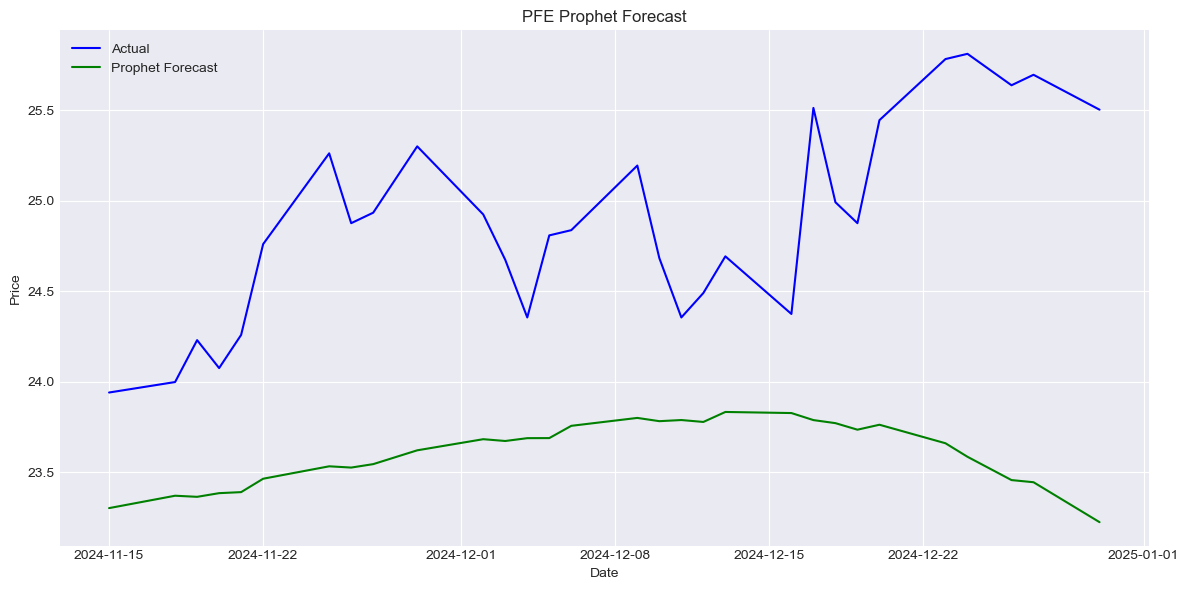

In [11]:
# Select the series for the desired ticker (e.g., 'PFE') and ensure it's numeric
series = pd.to_numeric(df_all[ticker], errors='coerce').dropna()

prophet_df = prepare_prophet_df(series)

model, forecast_df = fit_prophet_model(prophet_df, forecast_days=30)

true_prices = series[-30:]  # Adjust if your split is different
mae, mse, rmse, prophet_preds = evaluate_prophet(true_prices, forecast_df)

print("📌 Prophet Evaluation:")
print("MAE: ", round(mae, 4))
print("MSE: ", round(mse, 4))
print("RMSE:", round(rmse, 4))

plot_prophet(forecast_df, true_prices, ticker=ticker)
